In [1]:
# Imports
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [112]:
# Load data set
file_path = "./clean_eeg_data.csv"
eeg_data = pd.read_csv(file_path)

In [36]:
'''eeg_data['id'] = eeg_data.apply(lambda row: str(row['SubjectID']) +str(row['VideoID']),axis=1)
eeg_data.groupby(['predefinedlabel'])['id'].nunique()
eeg_data['id'].nunique()
eeg_data.query("SubjectID == 0 and VideoID == 0")'''

'eeg_data[\'id\'] = eeg_data.apply(lambda row: str(row[\'SubjectID\']) +str(row[\'VideoID\']),axis=1)\neeg_data.groupby([\'predefinedlabel\'])[\'id\'].nunique()\neeg_data[\'id\'].nunique()\neeg_data.query("SubjectID == 0 and VideoID == 0")'

## Analyzing Data Distributions

### Histograms

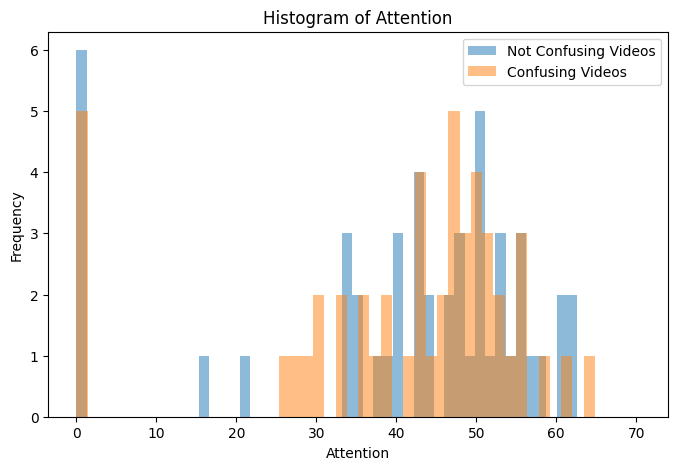

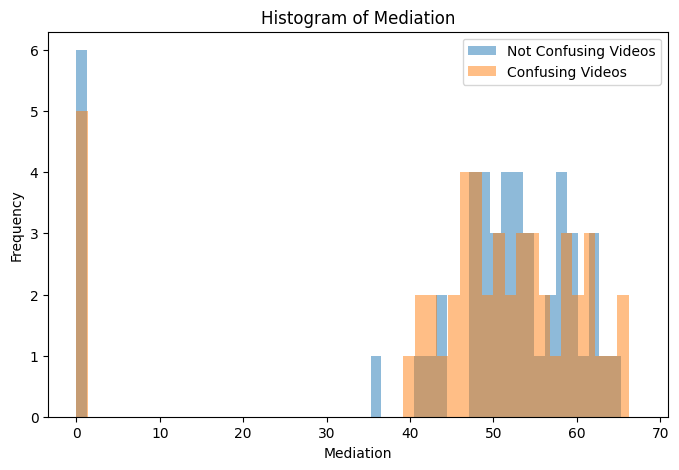

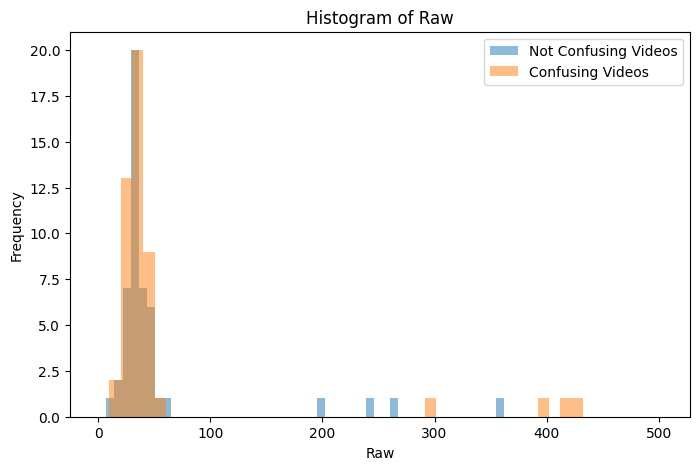

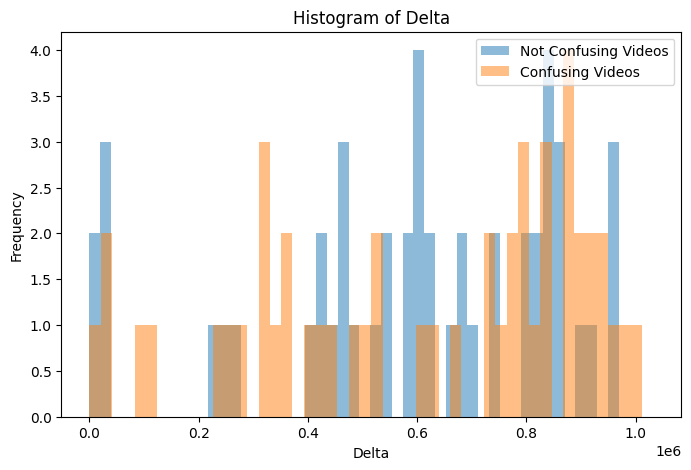

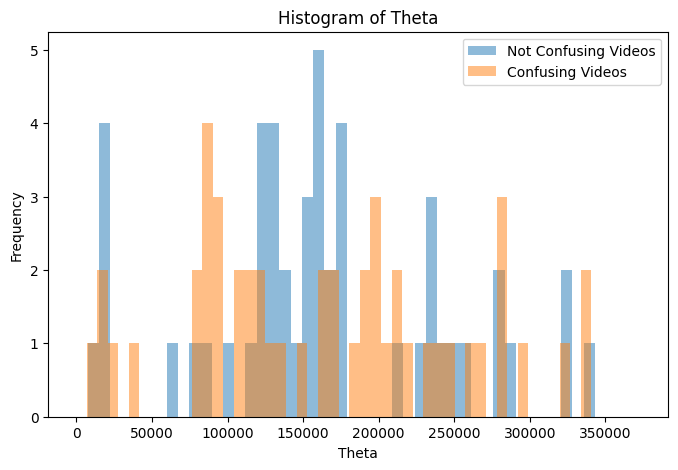

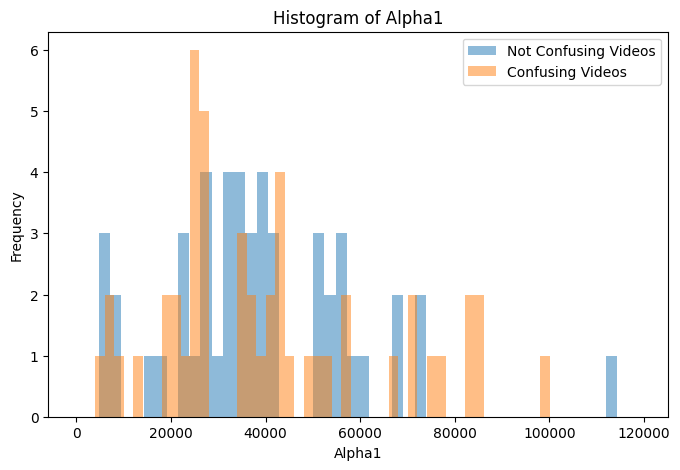

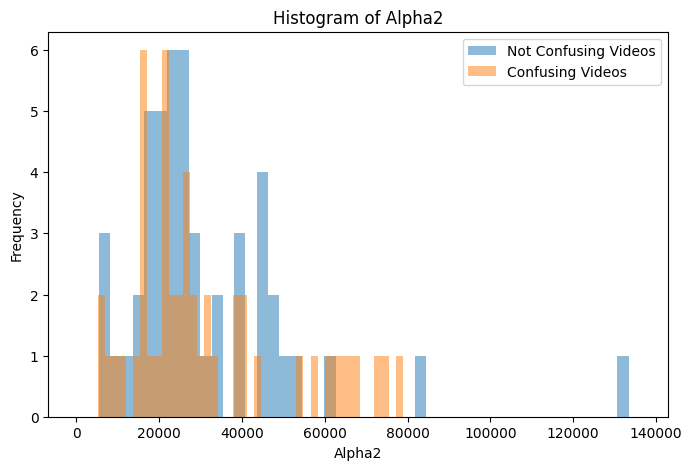

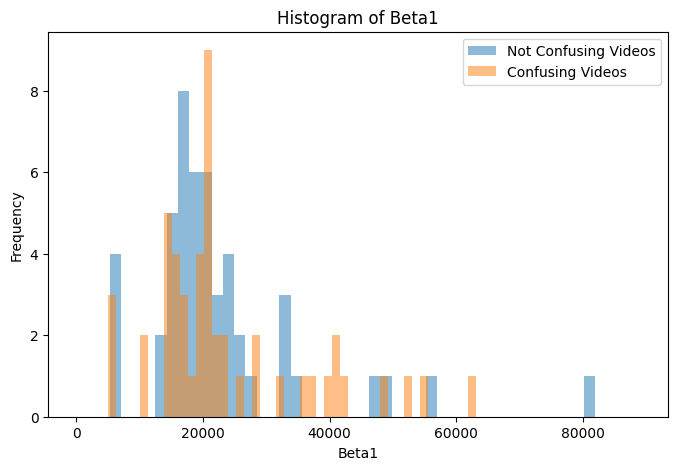

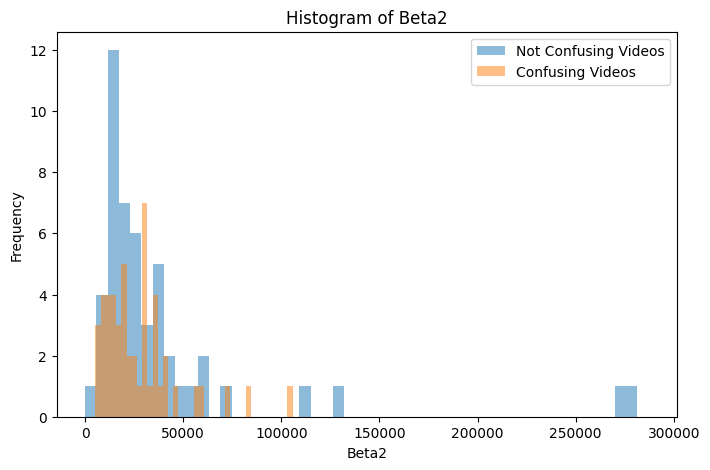

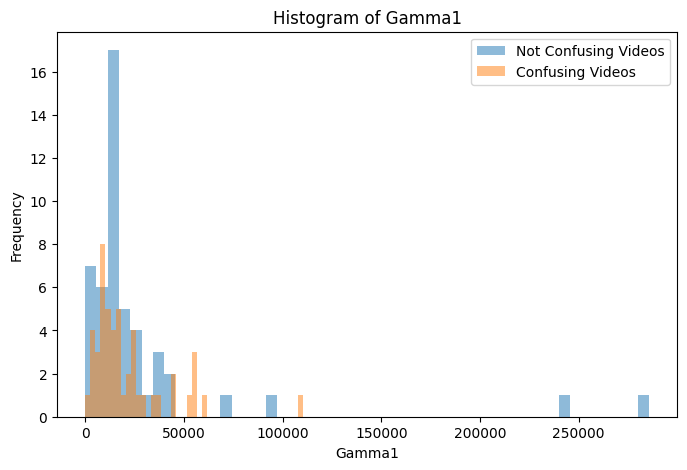

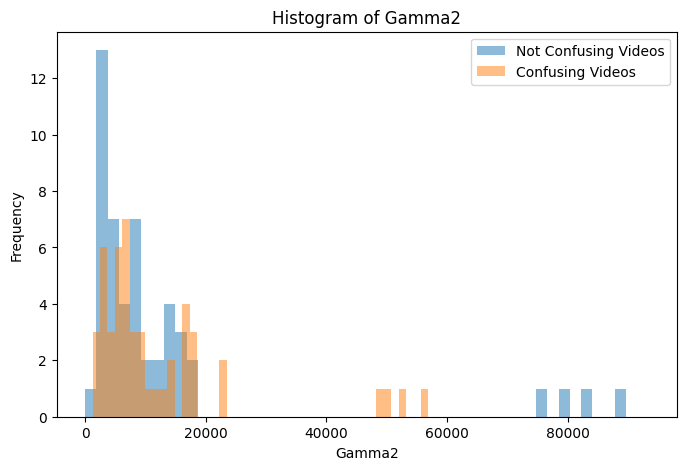

In [37]:
# Dividing the events based on their pre-defined lables -
# Confusing or not. 
not_confusing_videos = eeg_data[eeg_data['predefinedlabel'] == 0]
confusing_videos = eeg_data[eeg_data['predefinedlabel'] == 1]

# Plot histograms for each column for both groups
# We want to look only at the numeric columns, so we drop the columns we dont want, and make the othres in to a list.
# Our for loop goes throgh all remaing columns and creates plots for each group - Confusing vs not Confusing. 
for col in eeg_data.drop(['VideoID','SubjectID','predefinedlabel','user-definedlabeln','level_0','index'],axis=1).columns.to_list():
    # Creating new figure for the plot
    plt.figure(figsize=(8, 5))
    # Histogram of the not confusing videos. 
    # We take the data ranging from 0 to 0.99 percentile to exlude extreme outliers. 
    plt.hist(not_confusing_videos[col], alpha=0.5,range=(0,not_confusing_videos[col].quantile(0.99)), label='Not Confusing Videos', bins=50)
    # The same Histogram for the confusing videos.
    plt.hist(confusing_videos[col], alpha=0.5,range=(0,confusing_videos[col].quantile(0.99)), label='Confusing Videos', bins=50)
    # Adding title
    plt.title(f'Histogram of {col}')
    # Adding title for x-axis
    plt.xlabel(col)
    # Adding title for y-axis
    plt.ylabel('Frequency')
    # Adding a legend to explain the labels.
    plt.legend(loc='upper right')
    # Showing the histograms. 
    plt.show()


### Normality test

In [48]:
confusing_videos.columns

Index(['level_0', 'index', 'SubjectID', 'VideoID', 'predefinedlabel',
       'user-definedlabeln', 'Attention', 'Mediation', 'Raw', 'Delta', 'Theta',
       'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2'],
      dtype='object')

In [49]:
from scipy.stats import shapiro
normal_confusing_columns = []
normal_not_confusing_columns = []
# Perform Shapiro-Wilk test on each numerical column
for column in confusing_videos.drop(['user-definedlabeln','predefinedlabel','level_0','index'],axis=1).columns.to_list():
    # confusing
    data = confusing_videos[column].dropna()  # Drop missing values
    stat, p_value = shapiro(data)
    if p_value > 0.05:
       normal_confusing_columns.append(column)
    # not confusing
    data = not_confusing_videos[column].dropna()  # Drop missing values
    stat, p_value = shapiro(data)
    if p_value > 0.05:
       print(p_value)
       normal_not_confusing_columns.append(column)

0.08251032371949338


In [51]:
set(normal_confusing_columns).intersection(set(normal_not_confusing_columns))

{'Theta'}

### T Test on Theta

In [52]:

from scipy.stats import ttest_rel

# Assuming the variable to analyze is 'Theta' and we need to compare two conditions
# Replace 'Condition1' and 'Condition2' with actual column names for confusing and non-confusing videos
not_confusing_videos_sorted = not_confusing_videos.sort_values(by='SubjectID').reset_index(drop=True)
confusing_videos_sorted = confusing_videos.sort_values(by='SubjectID').reset_index(drop=True)



In [54]:
not_confusing_videos.shape,confusing_videos.shape ## we can see that they are the same shape, therefore index to index match

((50, 17), (50, 17))

In [56]:


# Perform the paired t-test
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(confusing_videos_sorted['Theta'],not_confusing_videos_sorted['Theta'])

# Display results
t_stat, p_value

(np.float64(0.10811288557761876), np.float64(0.914347640030539))

## Decision Tree

In [124]:
dataset.head()

,SubjectID,VideoID,predefinedlabel,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2
0,0.0,0.0,0.0,55.256944,53.826389,46.986111,544315.097222,124965.590278,36693.701389,25875.298611,20108.791667,40268.763889,40729.284722,16817.062500
1,0.0,1.0,0.0,43.621429,48.621429,28.800000,739737.292857,161064.228571,34918.028571,25078.935714,22157.307143,37410.728571,36758.700000,14519.407143
2,0.0,2.0,0.0,43.978873,47.316901,13.154930,694078.084507,149816.873239,30493.873239,21667.591549,21888.338028,36446.436620,33908.873239,14545.845070
3,0.0,3.0,0.0,51.057377,51.844262,34.713115,600823.688525,162653.360656,33367.278689,26281.500000,17224.278689,43706.524590,41438.213115,16558.631148
4,0.0,4.0,0.0,55.224138,47.474138,30.008621,546628.017241,126893.948276,23113.844828,17017.051724,15955.879310,36427.836207,36024.818966,14752.655172


In [148]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score

In [164]:
dataset = eeg_data

In [165]:
dataset = dataset.drop(['index','user-definedlabeln','level_0'],axis=1)

In [173]:
acc = 0
prec = 0
recall = 0
N_EXPERIMENTS = 1000
for exp in range(N_EXPERIMENTS):
    train_x, test_x, train_y, test_y = train_test_split(dataset.drop(['SubjectID','predefinedlabel','VideoID'],axis=1),dataset['predefinedlabel'])
    model = DecisionTreeClassifier()
    model.fit(train_x,train_y)
    model_pred_train = model.predict(train_x)
    model_pred_test = model.predict(test_x)

    acc+=accuracy_score(test_y,model_pred_test)
    prec+=precision_score(test_y,model_pred_test)
    recall+=recall_score(test_y,model_pred_test)
print(acc/N_EXPERIMENTS)
print(prec/N_EXPERIMENTS)
print(recall/N_EXPERIMENTS)

0.5302000000000001
0.531902614147119
0.541068840756767


In [174]:
N_EXPERIMENTS = 1000
acc = 0
prec = 0
recall = 0
for experiment in range(N_EXPERIMENTS):
    random_model_pred = np.random.choice([0, 1], size=len(test_y), p=[0.5,0.5])
    acc+=accuracy_score(test_y,random_model_pred)
    prec+=precision_score(test_y,random_model_pred)
    recall+=recall_score(test_y,random_model_pred)
print(acc/N_EXPERIMENTS)
print(prec/N_EXPERIMENTS)
print(recall/N_EXPERIMENTS)

0.4987599999999998
0.47840320322951874
0.49849999999999955
